###Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Penyakit_Padi/dataset
%ls

/content/drive/MyDrive/Penyakit_Padi/dataset
blight_smut_spot/  logs/                   split_2_baru/  split_2_tomat/
dataset_tomat/     ricenet_2_split_v3.png  split_2_part/  split_3_part/


### Preprocessing

#### Splitting Data

In [ ]:
!pip install split-folders # instalasi library splitfolders

import splitfolders # inisialisasi splitfolders

src_dir = '/content/drive/MyDrive/Penyakit_Padi/dataset/blight_smut_spot'
dest_dir = '/content/drive/MyDrive/Penyakit_Padi/dataset/split_3_part'

splitfolders.ratio(src_dir, output=dest_dir, seed=42, ratio=(.9, .1)) # pembagian data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 120 files [00:56,  2.11 files/s]


#### Import Library

In [ ]:
import os # manipulasi direktori data
import cv2 # manipulasi citra
import numpy as np # manipulasi matriks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

import tensorflow.keras as tfkr
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

#### Show Data

In [ ]:
base_dir = '/content/drive/MyDrive/Penyakit_Padi/dataset'

splitted_dir = os.path.join(base_dir, 'split_3_part')

train_dir = os.path.join(splitted_dir, 'train')
blight_train_dir = os.path.join(train_dir, 'Bacterial leaf blight')
spot_train_dir = os.path.join(train_dir, 'Brown spot')
smut_train_dir = os.path.join(train_dir, 'Leaf smut')

val_dir = os.path.join(splitted_dir, 'val')
blight_val_dir = os.path.join(val_dir, 'Bacterial leaf blight')
spot_val_dir = os.path.join(val_dir, 'Brown spot')
smut_val_dir = os.path.join(val_dir, 'Leaf smut')

In [ ]:
print("Total Train Blight:", len(os.listdir(blight_train_dir)))
print("Total Train Spot:", len(os.listdir(spot_train_dir)))
print("Total Train Smut:", len(os.listdir(smut_train_dir)))
print('-'*30)
print("Total Val Blight:", len(os.listdir(blight_val_dir)))
print("Total Val Spot:", len(os.listdir(spot_val_dir)))
print("Total Val Smut:", len(os.listdir(smut_val_dir)))

Total Train Blight: 36
Total Train Spot: 36
Total Train Smut: 36
------------------------------
Total Val Blight: 4
Total Val Spot: 4
Total Val Smut: 4


In [ ]:
data_dir = os.path.join(base_dir, 'blight_smut_spot')

blight_dir = os.path.join(data_dir, 'Bacterial leaf blight')
spot_dir = os.path.join(data_dir, 'Brown spot')
smut_dir = os.path.join(data_dir, 'Leaf smut')

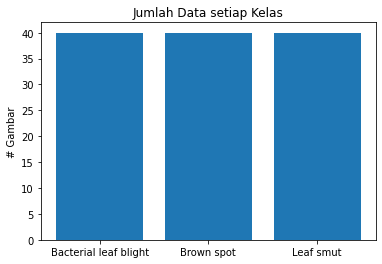

In [ ]:
import matplotlib.pyplot as plt
data_per_class = {
    'Bacterial leaf blight': len(os.listdir(blight_dir)),
    'Brown spot': len(os.listdir(spot_dir)),
    'Leaf smut': len(os.listdir(smut_dir))
    }

plt.bar(data_per_class.keys(), data_per_class.values());
plt.title("Jumlah Data setiap Kelas");
plt.ylabel('# Gambar');

In [ ]:
blight_img_file = os.path.join(blight_train_dir, os.listdir(blight_train_dir)[0])
spot_img_file = os.path.join(spot_train_dir, os.listdir(spot_train_dir)[0])
smut_img_file = os.path.join(smut_train_dir, os.listdir(smut_train_dir)[0])

img_file = [blight_img_file, spot_img_file, smut_img_file]
img_file

['/content/drive/MyDrive/Penyakit_Padi/dataset/split_3_part/train/Bacterial leaf blight/DSC_0377.JPG',
 '/content/drive/MyDrive/Penyakit_Padi/dataset/split_3_part/train/Brown spot/DSC_0111.jpg',
 '/content/drive/MyDrive/Penyakit_Padi/dataset/split_3_part/train/Leaf smut/DSC_0317.JPG']

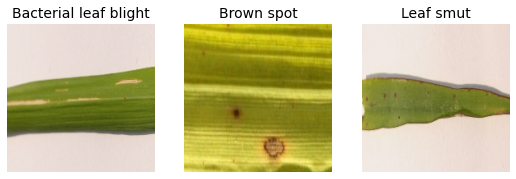

In [ ]:
import matplotlib.pyplot as plt

nrows = 1
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, img_path in enumerate(img_file):
    plt.subplot(nrows, ncols, i + 1)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (180,180))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_label = img_path.split(os.path.sep)[-2]

    plt.grid(False)
    plt.axis(False)
    plt.title(true_label, fontdict={'fontsize': 14})
    plt.imshow(img)

plt.show()

#### Augmentasi

In [ ]:
aug = tfkr.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tfkr.applications.resnet.preprocess_input,
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=True
    )

train_gen = aug.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    target_size=(224, 224)
    )

val_gen = aug.flow_from_directory(
    val_dir,
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    target_size=(224, 224)
    )

Found 108 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


### Modeling

#### ResNet101 base

In [ ]:
model_n_weight_dir = '/content/drive/MyDrive/Colab_Notebooks/ResNet101_weight'
wp = model_n_weight_dir + '/(3)resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
ResNet101_base = tfkr.applications.resnet.ResNet101(
    include_top=False,
    # pooling='avg',
    weights=wp,
    input_tensor=None,
    input_shape=(224, 224, 3)
    )

for layer in ResNet101_base.layers:
  layer.trainable = False

#### Base adding

In [ ]:
model = tfkr.models.Sequential()

model.add(ResNet101_base)

model.add(tfkr.layers.Flatten())

model.add(tfkr.layers.Dense(128, activation='relu'))
model.add(tfkr.layers.BatchNormalization())
model.add(tfkr.layers.Dropout(0.3))

model.add(tfkr.layers.Dense(32, activation='relu'))
model.add(tfkr.layers.BatchNormalization())
model.add(tfkr.layers.Dropout(0.1))

model.add(tfkr.layers.Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                        

In [ ]:
# model = tfkr.models.Sequential()

# model.add(ResNet101_base)

# model.add(tfkr.layers.Flatten())

# model.add(tfkr.layers.Dense(512, activation='relu'))
# model.add(tfkr.layers.BatchNormalization())
# model.add(tfkr.layers.Dropout(0.7))
# model.add(tfkr.layers.Dropout(0.7))

# model.add(tfkr.layers.Dense(64, activation='relu'))
# model.add(tfkr.layers.BatchNormalization())
# model.add(tfkr.layers.Dropout(0.3))
# model.add(tfkr.layers.Dropout(0.3))

# model.add(tfkr.layers.Dense(3, activation='softmax'))

# print(model.summary())

#### Model architecture viz

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(ResNet101_base,
#            to_file='ricenet_2_split_v3.png',
#            show_shapes=True,
#         #    show_layer_names=False
#            )

#### Compiling

In [ ]:
model.compile(
    optimizer=tfkr.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error',
    # loss='categorical_crossentropy',
    metrics =['accuracy']
    )

#### Callback

In [ ]:
target_dir = '/content/drive/MyDrive/Colab_Notebooks/Andre_rice_leaf_diseases_class'
directory_to_save_best_model_file = target_dir + '/ricenet_best_cheskpoint_v4.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file,
                             monitor='val_accuracy',
                             verbose = 1,
                             save_best_only = True
                             )

#### Fitting

In [ ]:
H = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=best_model,
    verbose=1
    )

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.4537 
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to /content/drive/MyDrive/Colab_Notebooks/Andre_rice_leaf_diseases_class/ricenet_best_cheskpoint_v4.h5
2/2 [==============================] - 28s 8s/step - loss: 0.3869 - accuracy: 0.4537 - val_loss: 0.2209 - val_accuracy: 0.6667
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.7315
Epoch 2: val_accuracy did not improve from 0.66667
2/2 [==============================] - 5s 2s/step - loss: 0.2416 - accuracy: 0.7315 - val_loss: 0.2222 - val_accuracy: 0.6667
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.8519
Epoch 3: val_accuracy improved from 0.66667 to 0.83333, saving model to /content/drive/MyDrive/Colab_Notebooks/Andre_rice_leaf_diseases_class/ricenet_best_cheskpoint_v4.h5
2/2 [==============================] - 7s 5s/step - loss: 0.1703 - accuracy

#### Save Model

In [ ]:
import json

target_dir = '/content/drive/MyDrive/Colab_Notebooks/Andre_rice_leaf_diseases_class'

# simpan history model
history_dict = H.history
json.dump(history_dict, open(target_dir + '/ricenet_split_2_v4.json', 'w'))

# simpan model dan weight-nya
model.save(target_dir + '/ricenet_split_2_v4.h5')

#### Load Model Weight and History

In [ ]:
from keras.models import load_model
import json

target_dir = '/content/drive/MyDrive/Colab_Notebooks/Andre_rice_leaf_diseases_class'
model = load_model(target_dir + '/ricenet_best_cheskpoint_v4.h5')
history = json.load(open(target_dir + '/ricenet_split_2_v4.json', 'r'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                        

### Evaluation

In [ ]:
loss, acc = model.evaluate(val_gen)

1/1 [==============================] - 3s 3s/step - loss: 0.0291 - accuracy: 1.0000


#### Acc and Loss Plot

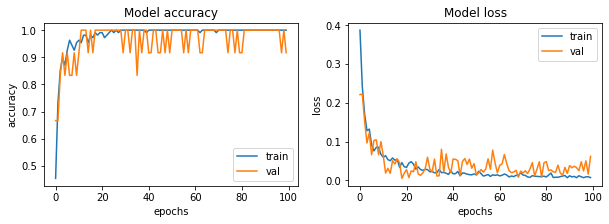

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[met])
    ax[i].plot(history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### Classification Report

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input

val_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

val_gen = val_aug.flow_from_directory(val_dir,
                                      batch_size=64,
                                      class_mode=None,
                                      shuffle=False,
                                      target_size=(224, 224))

Found 12 images belonging to 3 classes.


In [ ]:
from sklearn.metrics import classification_report

y_true = val_gen.classes

pred_result = model.predict(val_gen)
y_pred = np.argmax(pred_result, axis=-1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



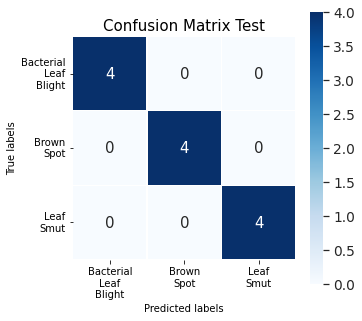

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = val_gen.class_indices
labels = [label.replace(" ", "\n").title() for label in labels]

cmatrix_result = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
ax = plt.subplot()

data = np.asarray(cmatrix_result).reshape(3,3)

sns.set(font_scale=1.25)
sns.heatmap(data,
            annot=True,
            ax=ax,
            cmap="Blues",
            square=True,
            linewidths=.3,
            xticklabels=labels,
            yticklabels=labels
            )

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.yticks(rotation=0)
plt.title('Confusion Matrix Test')
plt.show()

#### Image Prediction

In [ ]:
def pred_img(img_path):
    img = load_img(img_path, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    pred_result = model.predict(img)
    pred_value = np.argmax(pred_result[0])
    confidence_percent = np.max(pred_result[0]) * 100
    pred_label = 'Bacterial leaf blight' if pred_value == 0 else 'Brown spot' if pred_value == 1 else 'Leaf smut'
    return pred_label, confidence_percent

In [ ]:
import os
blight_dir = [os.path.join(blight_val_dir, fname) for fname in os.listdir(blight_val_dir)[:3]]
spot_dir = [os.path.join(spot_val_dir, fname) for fname in os.listdir(spot_val_dir)[:3]]
smut_dir = [os.path.join(smut_val_dir, fname) for fname in os.listdir(smut_val_dir)[:3]]

rice_diseases = blight_dir + spot_dir + smut_dir

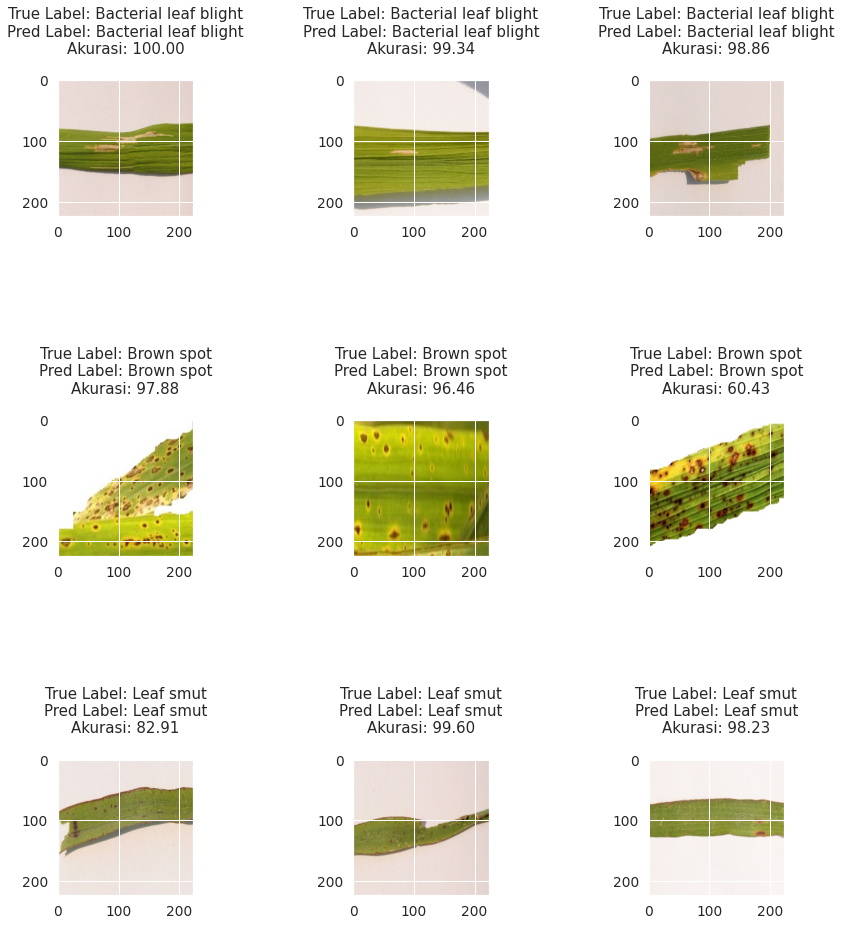

In [ ]:
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

nrows = 3
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, img_path in enumerate(rice_diseases):
    plt.subplot(nrows, ncols, i + 1)
    plt.subplots_adjust(hspace=1.5)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_label = img_path.split(os.path.sep)[-2]
    pred_result = pred_img(img_path)
    pred_label = pred_result[0]
    confidence_percent = pred_result[1]
    # pred_time = pred_result[2]

    plt.title(f"True Label: {true_label}\nPred Label: {pred_label}\nAkurasi: {confidence_percent:.2f}", y=1.15)
    plt.imshow(img)

plt.show()